In [90]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [91]:
import liana as li

In [92]:
from matplotlib.pyplot import hist

In [93]:
counts = pd.read_csv("data/counts_mat.csv")
weights = pd.read_csv("data/weight_mat.csv")

In [94]:
var = pd.DataFrame(counts[['Unnamed: 0']]).set_index('Unnamed: 0')
var.index.name = None

In [95]:
adata = sc.AnnData(X=csr_matrix(counts.drop(counts.columns[0], axis=1), dtype=np.float32).T, var=var)

In [96]:
adata.obsm['proximity'] = csr_matrix(weights)

In [97]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [98]:
adata

AnnData object with n_obs × n_vars = 260 × 43
    obsm: 'proximity'

In [99]:
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2"], "receptor":["Gucy1b3", "Mtor", "Tuba1a"]})

In [100]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

Using `.X`!
Converting mat to CSR format


In [101]:
lr_res

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
0,Dnm1l&Gucy1b3,Dnm1l,Gucy1b3,Dnm1l,Gucy1b3,2.682889,0.950000,3.117442,0.976923,0.950000
1,Arrb1&Mtor,Arrb1,Mtor,Arrb1,Mtor,2.665413,0.957692,2.298451,0.907692,0.907692
2,Igf2&Tuba1a,Igf2,Tuba1a,Igf2,Tuba1a,1.924077,0.892308,6.466562,1.000000,0.892308


Correlations

In [102]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [103]:
x, y = ligand_mat[0, :].A.flatten(), receptor_mat[0, :].A.flatten()

In [104]:
from scipy.stats import spearmanr, pearsonr, pointbiserialr, kendalltau

In [105]:
pearsonr(x, y)

(0.12061560721706954, 0.05206512033238492)

One by One

In [106]:
def wcor(x, y, weight):
    weight_sum = np.sum(weight)
    
    numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
    denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
    denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2
    
    wcor = numerator / np.sqrt(denominator_x * denominator_y)
    
    return wcor

In [107]:
adata.obsm['proximity']

<260x260 sparse matrix of type '<class 'numpy.float64'>'
	with 3120 stored elements in Compressed Sparse Row format>

In [108]:
i = 0

In [109]:
# all weights = 1 (i.e. pearsonr)
wcor(x, y, np.repeat(1, x.shape[0]))

0.12061560565466811

In [110]:
weight = adata.obsm['proximity']

In [111]:
# calculate all local correlations
# technically, if we take i (a spot), x and y (e.g. genes),
# we go over all rows in w (i.e. every spot)
# and we re-calculate PC with the spatial weights 
# for the spots i to any other spot (j)
local_corrs = []
for i in range(weight.shape[0]):
    local_corrs.append(wcor(x, y, weight[i, :].A))
local_corrs = np.array(local_corrs)

(array([ 9., 25., 27., 37., 26., 43., 37., 35., 14.,  7.]),
 array([-0.58677481, -0.45093227, -0.31508972, -0.17924717, -0.04340463,
         0.09243792,  0.22828047,  0.36412302,  0.49996556,  0.63580811,
         0.77165066]),
 <BarContainer object of 10 artists>)

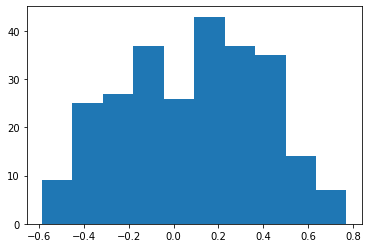

In [112]:
hist(local_corrs)

In [113]:
local_corrs[0:5]

array([-0.00132965,  0.17837803, -0.0006992 ,  0.0007183 , -0.21403439])

In [114]:
weight = weight[0, :].A

In [115]:
weight_sum = np.sum(weight)

numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2

# wcov
numerator / np.sqrt(denominator_x * denominator_y)

-0.0013296463642543616

In [116]:
numerator

-0.02042462054362204

In [117]:
denominator_x

27.1080042154029

In [118]:
denominator_y

8.70438613109468

In [119]:
weight_sum * np.sum(weight * x * y)

413.32909518769986

In [120]:
np.sum(weight * x) * np.sum(weight * y)

413.3495198082435

In [121]:
(weight * x)[0][0:5]

array([1.37200415, 1.59062576, 2.52672255, 0.        , 0.        ])

Vectorize

For one interaction at a time:

In [122]:
weight = adata.obsm["proximity"].A ## does it really need to be A?

In [123]:
weight_sums = np.sum(weight, axis = 1).flatten()

In [124]:
n1 = (weight_sums * np.sum(np.multiply(weight, x) * y, axis=1))
n1

array([413.32909519, 367.77565144, 384.96345094, 311.83233116,
       291.88845544, 229.55259411, 296.81639637, 244.39191989,
       262.03291758, 328.88626754, 286.1400844 , 440.94925182,
       449.77804841, 435.79750052, 464.84357456, 501.5987323 ,
       487.38977621, 444.22556469, 374.05188673, 427.45398769,
       404.17177861, 461.60641588, 434.8602097 , 353.04691204,
       424.64731557, 410.36329255, 400.67118665, 440.19714239,
       428.75038268, 370.82554049, 284.38660824, 327.77410411,
       351.00389891, 284.86294048, 262.02274057, 271.69670533,
       339.12686273, 322.29733764, 382.79244195, 337.56200154,
       317.97494821, 316.86057578, 412.93638871, 323.17805427,
       445.28981302, 321.29055645, 376.04829516, 303.24661213,
       437.39817712, 427.12560128, 381.02628954, 351.91516238,
       387.05688626, 323.46438147, 329.92737548, 393.12573454,
       282.36045012, 479.19658545, 435.22576729, 458.45570385,
       448.43811821, 368.06214603, 397.19390292, 417.46

In [125]:
n2 = np.sum(np.multiply(weight, x), axis=1) * np.sum(np.multiply(weight, y), axis=1)
n2

array([413.34951981, 364.04993142, 384.97718615, 311.80720578,
       300.28635934, 230.84554091, 296.87001313, 247.64965657,
       265.26917936, 321.00243712, 284.98079694, 442.18041878,
       446.46225784, 431.27686073, 460.09720436, 500.91631453,
       484.67684591, 433.53421394, 358.39917712, 413.99378104,
       398.84212871, 463.8748456 , 423.9611496 , 332.43945387,
       405.44214778, 388.24231756, 392.95986166, 436.65139367,
       435.16721534, 366.75796276, 280.72670949, 317.25634725,
       347.50209925, 286.74913205, 266.23794642, 267.34788731,
       335.37092245, 316.73109636, 377.03185749, 343.24745157,
       320.89120283, 299.1494663 , 421.02189612, 291.23769656,
       451.95757341, 308.21391039, 317.24875795, 275.26719015,
       409.69580539, 373.36623128, 386.43741098, 352.44718267,
       347.99258824, 304.70799884, 316.6128232 , 379.31939856,
       268.91057482, 478.91300641, 424.35484693, 458.16672364,
       451.10119935, 366.54643861, 396.65551842, 417.58

In [126]:
numerator = n1 - n2

In [127]:
numerator[0:5]

array([-0.02042462,  3.72572002, -0.01373521,  0.02512538, -8.3979039 ])

In [128]:
denominator_x = weight_sum * np.sum(np.multiply(weight, (x**2)), axis = 1) - np.sum(np.multiply(weight,  x), axis=1)**2
denominator_y = weight_sum * np.sum(np.multiply(weight, (y**2)), axis = 1) - np.sum(np.multiply(weight,  y), axis=1)**2

In [129]:
denominator_x.shape

(260,)

In [130]:
denominator_x[0:5]

array([27.10800422, 25.21338601, 29.18442814, 27.59649804, 26.70265811])

In [131]:
denominator_y[0:5]

array([ 8.70438613, 17.30240674, 13.22245209, 44.33641497, 57.65276927])

In [132]:
local_corrs = numerator / np.sqrt(denominator_x * denominator_y)

(array([ 9., 25., 27., 37., 26., 43., 37., 35., 14.,  7.]),
 array([-0.58677481, -0.45093227, -0.31508972, -0.17924717, -0.04340463,
         0.09243792,  0.22828047,  0.36412302,  0.49996556,  0.63580811,
         0.77165066]),
 <BarContainer object of 10 artists>)

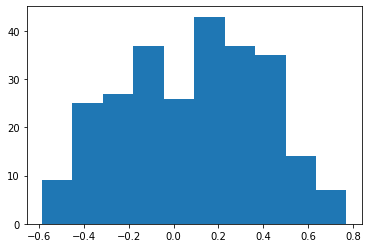

In [133]:
hist(local_corrs)

All local corrs for all interactions

In [134]:
ligand_mat

<3x260 sparse matrix of type '<class 'numpy.float32'>'
	with 728 stored elements in Compressed Sparse Column format>

In [135]:
receptor_mat

<3x260 sparse matrix of type '<class 'numpy.float32'>'
	with 750 stored elements in Compressed Sparse Column format>

In [144]:
weight = adata.obsm["proximity"].A.T ## does it really need to be A?

In [145]:
weight_sums = np.sum(weight, axis = 0).flatten()

In [146]:
x_mat = ligand_mat.A.T
y_mat = receptor_mat.A.T

In [147]:
n1 = (((x_mat * y_mat).T @ weight) * weight_sums.T)

In [148]:
n1[0:5, 0]

array([413.32909371, 365.15943805, 524.96514881])

In [149]:
n2 = (x_mat.T @ weight) * (y_mat.T @ weight)

In [150]:
numerator = n1 - n2

In [152]:
numerator[0,0:5]

array([-0.02042609,  3.72572379, -0.01373214,  0.02512774, -8.39790343])

In [160]:
denominator_x = (weight_sums * (x_mat ** 2).T @ weight) - (x_mat.T @ weight)**2
denominator_y = (weight_sums * (y_mat ** 2).T @ weight) - (y_mat.T @ weight)**2

In [161]:
denominator_x[0:5, 0]

array([27.10800422, 48.55611783, 40.57299122])

In [162]:
denominator_y[0:5, 0]

array([ 8.70438613, 15.51988565,  5.81770928])

In [163]:
denominator_x

array([[ 27.10800422,  25.21338601,  29.18442814,  27.59649804,
         26.70265811,  55.3537035 ,  30.12125141,  47.01578326,
         81.41142478,  62.15862898,  82.58646053,  16.36128015,
         19.11291709,  21.96501953,  17.65254864,  27.90325532,
         16.33641846,  24.13317626,  68.89712128,  64.50301159,
         34.39160405,  21.31441263,  59.86198289,  87.71780448,
         72.17459772,  86.43500933,  32.93801658,  36.93016169,
         26.08452288,  33.9621673 ,  75.64319151,  59.76099   ,
         47.8184806 ,  42.4506858 ,  76.00439238,  59.94939124,
         39.54584709,  44.44433833,  66.32344809,  36.63889649,
         27.1356769 ,  72.51309054,  20.71949336,  57.97152828,
         32.66195055,  51.31448421,  86.26886712,  72.18837821,
         39.2540309 ,  66.53619097,  11.24734811,  20.75931426,
         51.33368218,  62.97410768,  58.75022332,  45.9802889 ,
         65.41522456,  18.9716925 ,  27.52364134,  18.66183331,
         12.69264782,  33.58681862,  13.

In [164]:
corrs = (numerator / np.sqrt(denominator_x * denominator_y)).T

(array([ 9., 25., 27., 37., 26., 43., 37., 35., 14.,  7.]),
 array([-0.58677485, -0.4509323 , -0.31508976, -0.17924721, -0.04340467,
         0.09243788,  0.22828043,  0.36412297,  0.49996552,  0.63580806,
         0.77165061]),
 <BarContainer object of 10 artists>)

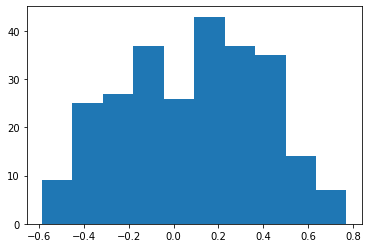

In [165]:
hist(corrs[:,0])